# AML Transaction Anomaly Detection Model

This notebook implements advanced anomaly detection for banking transactions using Isolation Forest and other machine learning techniques.

## Objectives:
- Detect unusual transaction patterns that may indicate money laundering
- Identify behavioral anomalies in customer transaction history
- Provide real-time scoring for incoming transactions
- Support the 7 AML controls with ML-based detection

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
import os
import sys

# Database connection
from sqlalchemy import create_engine

# Add parent directory to path for imports
# If feature_engineering.py is a local file, ensure it exists in the parent directory.
# If it is a package, install 
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully")

Libraries imported successfully


## Database Connection and Data Loading

In [4]:
import pandas as pd

# Load training data from the generated CSV file
print("Loading transaction data from CSV...")
df_transactions = pd.read_csv('C:/Users/abiri/Downloads/PatternDetect/generated_data/transaction_data_90_days.csv')

# Ensure 'created_at' is datetime type
df_transactions['created_at'] = pd.to_datetime(df_transactions['created_at'])

print(f"Dataset shape: {df_transactions.shape}")
print(f"Date range: {df_transactions['created_at'].min()} to {df_transactions['created_at'].max()}")

Loading transaction data from CSV...
Dataset shape: (5000, 25)
Date range: 2025-08-29 10:15:07 to 2025-08-29 10:15:09


## Exploratory Data Analysis

In [5]:
# Basic statistics
print("=== Dataset Overview ===")
print(f"Total transactions: {len(df_transactions):,}")
print(f"Unique customers: {df_transactions['customer_id'].nunique():,}")
print(f"Date range: {df_transactions['created_at'].min()} to {df_transactions['created_at'].max()}")
print(f"Total volume: ${df_transactions['base_amount'].sum():,.2f}")
print(f"Average transaction: ${df_transactions['base_amount'].mean():.2f}")
print(f"Suspicious transactions: {df_transactions['is_suspicious'].sum():,} ({df_transactions['is_suspicious'].mean()*100:.2f}%)")
print(f"Transactions with alerts: {df_transactions['has_alert'].sum():,} ({df_transactions['has_alert'].mean()*100:.2f}%)")

print("\n=== Transaction Types ===")
print(df_transactions['transaction_type'].value_counts())

print("\n=== Channels ===")
print(df_transactions['channel'].value_counts())

print("\n=== Currencies ===")
print(df_transactions['currency'].value_counts())

=== Dataset Overview ===
Total transactions: 5,000
Unique customers: 100
Date range: 2025-08-29 10:15:07 to 2025-08-29 10:15:09
Total volume: $12,440,131.59
Average transaction: $2488.03
Suspicious transactions: 2,467 (49.34%)
Transactions with alerts: 0 (0.00%)

=== Transaction Types ===
transaction_type
DEBIT       1692
CREDIT      1668
TRANSFER    1640
Name: count, dtype: int64

=== Channels ===
channel
ATM       1280
POS       1253
BRANCH    1236
ONLINE    1231
Name: count, dtype: int64

=== Currencies ===
currency
USD    5000
Name: count, dtype: int64


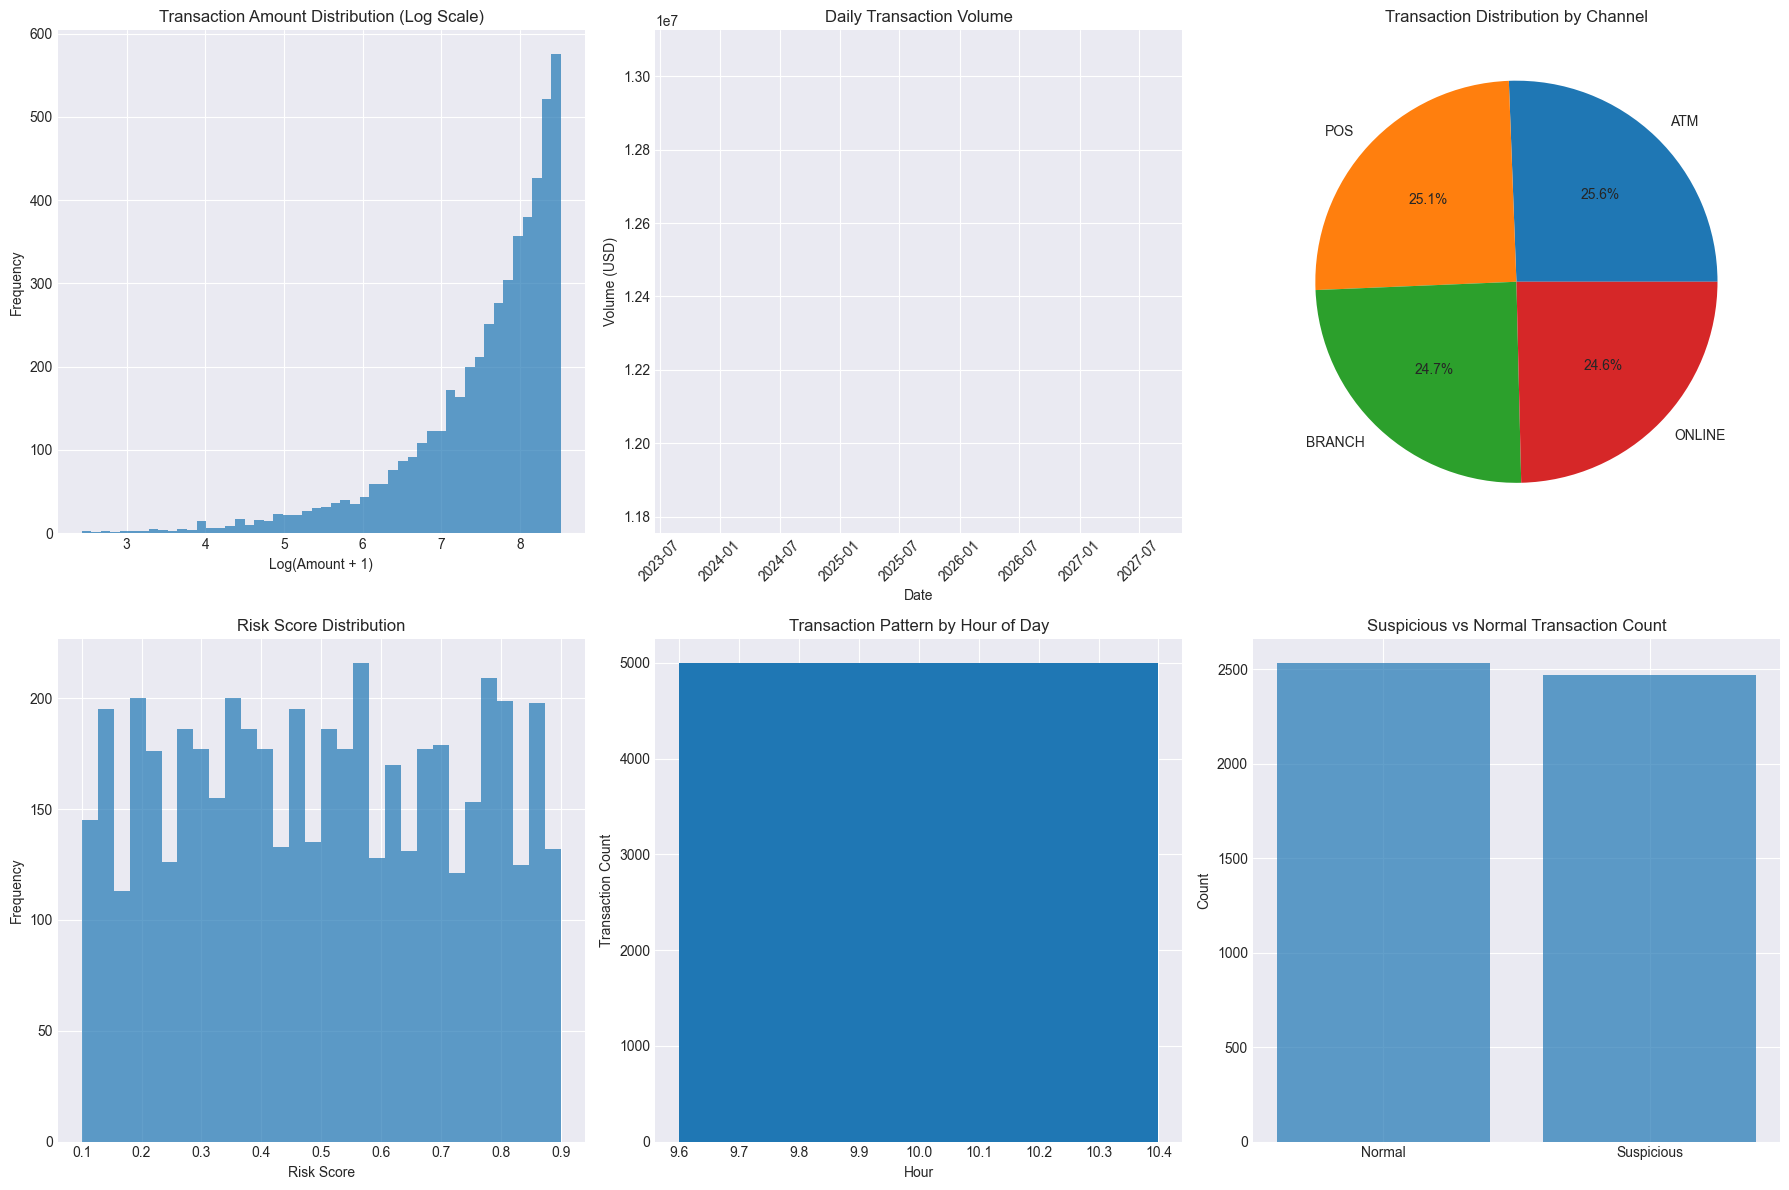


=== Suspicious Transaction Analysis ===
               count         mean
is_suspicious                    
0               2533  2464.301729
1               2467  2512.385614


In [6]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Transaction amount distribution
axes[0,0].hist(np.log1p(df_transactions['base_amount']), bins=50, alpha=0.7)
axes[0,0].set_title('Transaction Amount Distribution (Log Scale)')
axes[0,0].set_xlabel('Log(Amount + 1)')
axes[0,0].set_ylabel('Frequency')

# Transaction volume over time
daily_volume = df_transactions.groupby(df_transactions['created_at'].dt.date)['base_amount'].sum()
axes[0,1].plot(daily_volume.index, daily_volume.values)
axes[0,1].set_title('Daily Transaction Volume')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Volume (USD)')
axes[0,1].tick_params(axis='x', rotation=45)

# Channel distribution
channel_counts = df_transactions['channel'].value_counts()
axes[0,2].pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%')
axes[0,2].set_title('Transaction Distribution by Channel')

# Risk score distribution
axes[1,0].hist(df_transactions['risk_score'].dropna(), bins=30, alpha=0.7)
axes[1,0].set_title('Risk Score Distribution')
axes[1,0].set_xlabel('Risk Score')
axes[1,0].set_ylabel('Frequency')

# Hourly transaction pattern
hourly_txn = df_transactions.groupby(df_transactions['created_at'].dt.hour).size()
axes[1,1].bar(hourly_txn.index, hourly_txn.values)
axes[1,1].set_title('Transaction Pattern by Hour of Day')
axes[1,1].set_xlabel('Hour')
axes[1,1].set_ylabel('Transaction Count')

# Suspicious vs Normal transactions
susp_comparison = df_transactions.groupby('is_suspicious')['base_amount'].agg(['count', 'mean'])
axes[1,2].bar(['Normal', 'Suspicious'], susp_comparison['count'], alpha=0.7)
axes[1,2].set_title('Suspicious vs Normal Transaction Count')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\n=== Suspicious Transaction Analysis ===")
print(susp_comparison)

## Feature Engineering for Anomaly Detection

In [7]:
# Initialize feature engineering

def engineer_anomaly_features(df):
    """
    Create features specifically for anomaly detection
    """
    print("Engineering features for anomaly detection...")
    
    # Make a copy to avoid modifying original
    df_features = df.copy()
    
    # Basic transaction features
    df_features['amount_log'] = np.log1p(df_features['base_amount'])
    df_features['amount_zscore'] = (df_features['base_amount'] - df_features['base_amount'].mean()) / df_features['base_amount'].std()
    
    # Time-based features
    df_features['hour'] = pd.to_datetime(df_features['created_at']).dt.hour
    df_features['day_of_week'] = pd.to_datetime(df_features['created_at']).dt.dayofweek
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_night'] = ((df_features['hour'] < 6) | (df_features['hour'] > 22)).astype(int)
    df_features['is_business_hours'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 17) & (df_features['day_of_week'] < 5)).astype(int)
    
    # Customer behavioral features
    print("Computing customer behavioral features...")
    
    # Customer transaction frequency and amounts
    customer_stats = df_features.groupby('customer_id').agg({
        'base_amount': ['count', 'mean', 'std', 'min', 'max'],
        'created_at': ['min', 'max']
    }).reset_index()
    
    # Flatten column names
    customer_stats.columns = ['customer_id', 'txn_count', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'first_txn', 'last_txn']
    customer_stats['txn_std'] = customer_stats['txn_std'].fillna(0)
    customer_stats['customer_tenure_days'] = (customer_stats['last_txn'] - customer_stats['first_txn']).dt.days + 1
    customer_stats['txn_frequency'] = customer_stats['txn_count'] / customer_stats['customer_tenure_days']
    
    # Merge customer stats back
    df_features = df_features.merge(customer_stats[['customer_id', 'txn_count', 'txn_mean', 'txn_std', 'txn_frequency']], on='customer_id', how='left')
    
    # Transaction deviation from customer's normal behavior
    df_features['amount_deviation'] = np.abs(df_features['base_amount'] - df_features['txn_mean']) / (df_features['txn_std'] + 1e-6)
    df_features['amount_percentile'] = df_features.groupby('customer_id')['base_amount'].rank(pct=True)
    
    # Channel and transaction type encoding
    channel_risk = df_features.groupby('channel')['has_alert'].mean().to_dict()
    df_features['channel_risk'] = df_features['channel'].map(channel_risk)
    
    type_risk = df_features.groupby('transaction_type')['has_alert'].mean().to_dict()
    df_features['type_risk'] = df_features['transaction_type'].map(type_risk)
    
    # Cross-border and high-value indicators
    df_features['is_cross_border'] = df_features['is_cross_border'].astype(int)
    df_features['is_high_value'] = df_features['is_high_value'].astype(int)
    
    # PEP and customer risk
    df_features['is_pep'] = df_features['is_pep'].fillna(False).astype(int)
    risk_mapping = {'LOW': 1, 'MEDIUM': 2, 'HIGH': 3, 'CRITICAL': 4}
    df_features['customer_risk_numeric'] = df_features['risk_rating'].map(risk_mapping).fillna(1)
    
    # Counterparty features
    df_features['has_counterparty'] = (~df_features['counterparty_name'].isna()).astype(int)
    df_features['narrative_length'] = df_features['narrative'].fillna('').str.len()
    
    print(f"Feature engineering completed. Shape: {df_features.shape}")
    return df_features

# Apply feature engineering
df_features = engineer_anomaly_features(df_transactions)

# Select features for anomaly detection
anomaly_features = [
    'amount_log', 'amount_zscore', 'amount_deviation', 'amount_percentile',
    'hour', 'day_of_week', 'is_weekend', 'is_night', 'is_business_hours',
    'txn_count', 'txn_frequency', 'channel_risk', 'type_risk',
    'is_cross_border', 'is_high_value', 'is_pep', 'customer_risk_numeric',
    'has_counterparty', 'narrative_length'
]

print(f"\nSelected {len(anomaly_features)} features for anomaly detection:")
for feature in anomaly_features:
    print(f"  - {feature}")

Engineering features for anomaly detection...
Computing customer behavioral features...
Feature engineering completed. Shape: (5000, 43)

Selected 19 features for anomaly detection:
  - amount_log
  - amount_zscore
  - amount_deviation
  - amount_percentile
  - hour
  - day_of_week
  - is_weekend
  - is_night
  - is_business_hours
  - txn_count
  - txn_frequency
  - channel_risk
  - type_risk
  - is_cross_border
  - is_high_value
  - is_pep
  - customer_risk_numeric
  - has_counterparty
  - narrative_length


## Data Preprocessing and Feature Selection

Missing values per feature:
Series([], dtype: int64)

Dataset summary:
Total samples: 5000
Features: 19
Known anomalies: 2467 (49.34%)
Normal transactions: 2533 (50.66%)

Analyzing feature correlations...


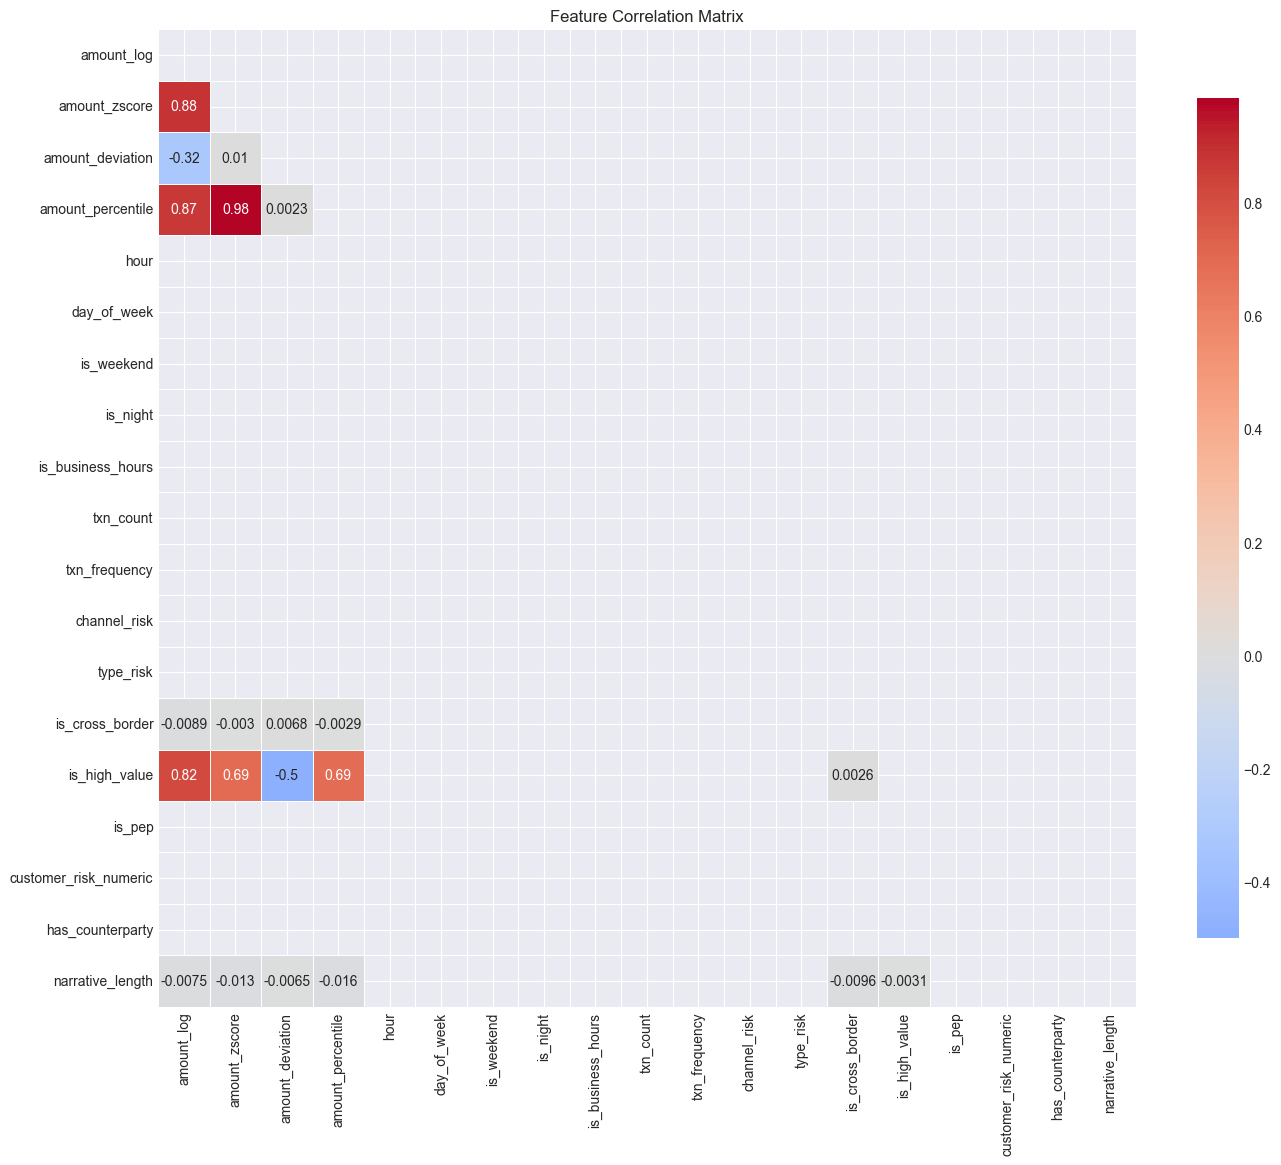


Highly correlated feature pairs (|r| > 0.8):
  amount_log <-> amount_zscore: 0.882
  amount_log <-> amount_percentile: 0.871
  amount_log <-> is_high_value: 0.817
  amount_zscore <-> amount_percentile: 0.984


In [8]:
# Prepare feature matrix
X = df_features[anomaly_features].copy()

# Handle missing values
print("Missing values per feature:")
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

# Fill missing values
X = X.fillna(X.median())

# Create target variable (1 for anomaly, 0 for normal)
# We'll use existing suspicious flags and alerts as ground truth
y_true = (df_features['is_suspicious'] | df_features['has_alert']).astype(int)

print(f"\nDataset summary:")
print(f"Total samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Known anomalies: {y_true.sum()} ({y_true.mean()*100:.2f}%)")
print(f"Normal transactions: {(~y_true.astype(bool)).sum()} ({(1-y_true.mean())*100:.2f}%)")

# Feature correlation analysis
print("\nAnalyzing feature correlations...")
correlation_matrix = X.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Identify highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found.")

## Feature Scaling and Dimensionality Reduction

Training set: 4000 samples
Test set: 1000 samples
Training anomalies: 1974 (49.35%)
Test anomalies: 493 (49.30%)

Applying feature scaling...
Performing PCA analysis...


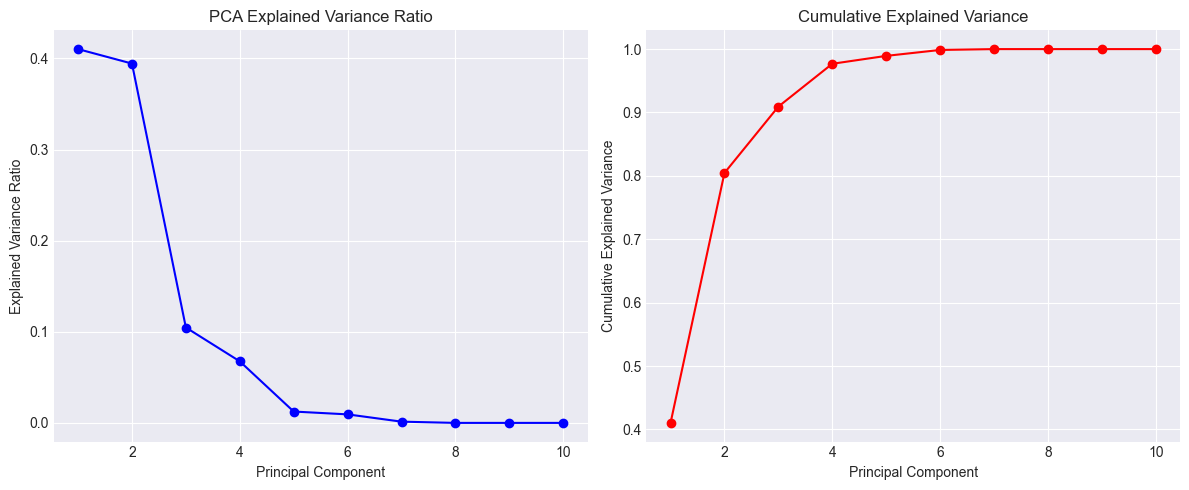

First 5 components explain 98.9% of variance
First 10 components explain 100.0% of variance


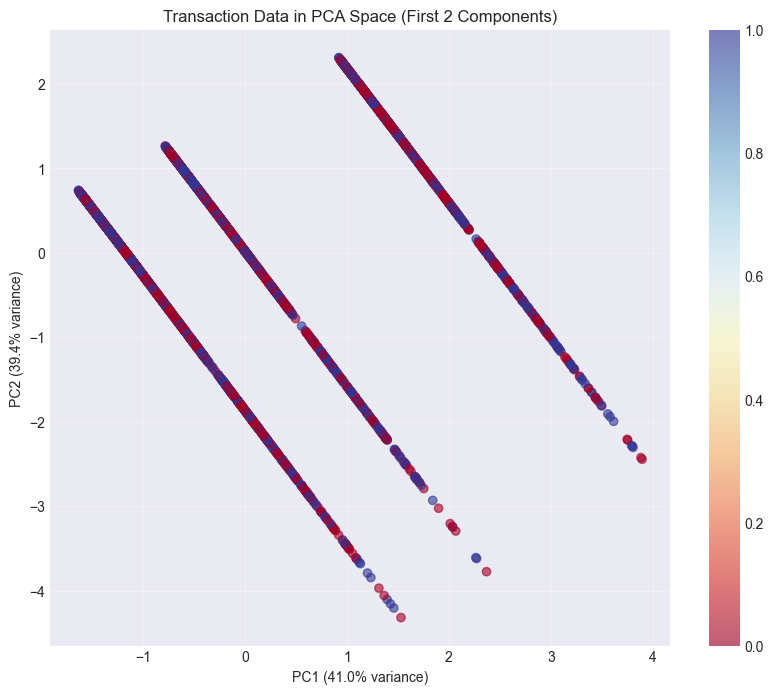

In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=0.2, random_state=42, stratify=y_true
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training anomalies: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Test anomalies: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

# Feature scaling
print("\nApplying feature scaling...")
scaler = RobustScaler()  # Less sensitive to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Principal Component Analysis for visualization and dimensionality reduction
print("Performing PCA analysis...")
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), pca.explained_variance_ratio_, 'bo-')
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"First 5 components explain {np.cumsum(pca.explained_variance_ratio_)[4]*100:.1f}% of variance")
print(f"First 10 components explain {np.cumsum(pca.explained_variance_ratio_)[9]*100:.1f}% of variance")

# Visualize data in 2D PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdYlBu', alpha=0.6)
plt.colorbar(scatter)
plt.title('Transaction Data in PCA Space (First 2 Components)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.grid(True, alpha=0.3)
plt.show()

## Isolation Forest Anomaly Detection Model

In [10]:
# Isolation Forest model training
print("Training Isolation Forest model...")

# For unsupervised learning, we use all training data
# contamination parameter should match expected anomaly rate
contamination_rate = y_train.mean()
print(f"Setting contamination rate to: {contamination_rate:.4f}")

# Initialize and train Isolation Forest
isolation_forest = IsolationForest(
    contamination=contamination_rate,
    random_state=42,
    n_estimators=200,
    max_samples='auto',
    max_features=1.0,
    bootstrap=False
)

# Train on scaled features
isolation_forest.fit(X_train_scaled)

print("Model training completed.")

# Predictions on training set
train_predictions = isolation_forest.predict(X_train_scaled)
train_scores = isolation_forest.decision_function(X_train_scaled)

# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
train_predictions_binary = (train_predictions == -1).astype(int)

print("\n=== Training Set Results ===")
print(f"Predicted anomalies: {train_predictions_binary.sum()} ({train_predictions_binary.mean()*100:.2f}%)")
print(f"Actual anomalies: {y_train.sum()} ({y_train.mean()*100:.2f}%)")

# Predictions on test set
test_predictions = isolation_forest.predict(X_test_scaled)
test_scores = isolation_forest.decision_function(X_test_scaled)
test_predictions_binary = (test_predictions == -1).astype(int)

print("\n=== Test Set Results ===")
print(f"Predicted anomalies: {test_predictions_binary.sum()} ({test_predictions_binary.mean()*100:.2f}%)")
print(f"Actual anomalies: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Training Isolation Forest model...
Setting contamination rate to: 0.4935
Model training completed.

=== Training Set Results ===
Predicted anomalies: 1974 (49.35%)
Actual anomalies: 1974 (49.35%)

=== Test Set Results ===
Predicted anomalies: 509 (50.90%)
Actual anomalies: 493 (49.30%)


## Model Evaluation and Performance Metrics

=== Classification Report - Test Set ===
              precision    recall  f1-score   support

      Normal       0.49      0.48      0.48       507
     Anomaly       0.48      0.49      0.49       493

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000


=== Confusion Matrix ===
Predicted:  Normal  Anomaly
Normal        241     266
Anomaly       250     243

=== Performance Metrics ===
Precision: 0.4774
Recall (Sensitivity): 0.4929
F1-Score: 0.4850
Specificity: 0.4753
False Positive Rate: 0.5247
False Negative Rate: 0.5071


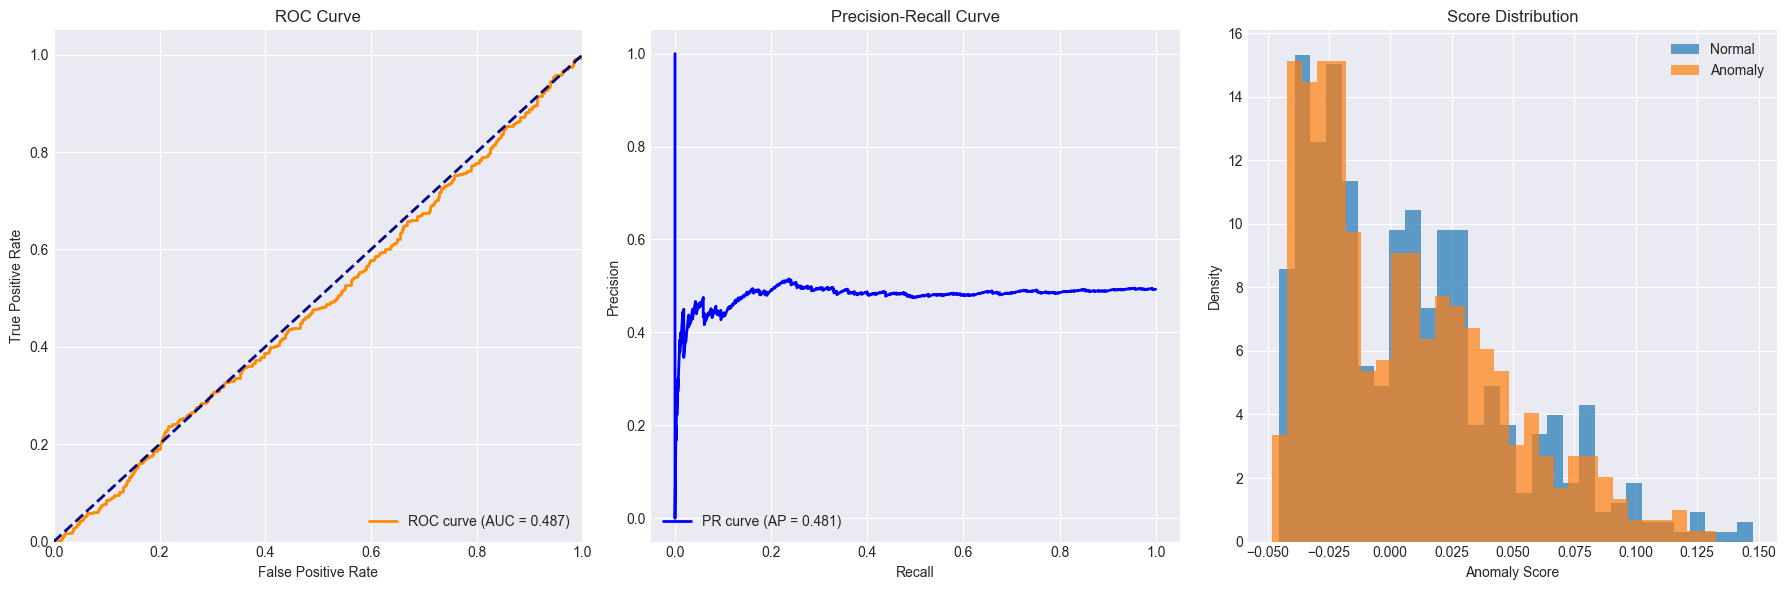


ROC AUC: 0.4874
Average Precision: 0.4812


In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

# Evaluation on test set
print("=== Classification Report - Test Set ===")
print(classification_report(y_test, test_predictions_binary, 
                          target_names=['Normal', 'Anomaly']))

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions_binary)
print("\n=== Confusion Matrix ===")
print("Predicted:  Normal  Anomaly")
print(f"Normal     {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Anomaly    {cm[1,0]:6d}  {cm[1,1]:6d}")

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n=== Performance Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")

# ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, -test_scores)  # Negative scores for proper ROC
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, -test_scores)
avg_precision = average_precision_score(y_test, -test_scores)

axes[1].plot(recall_vals, precision_vals, color='blue', lw=2, 
            label=f'PR curve (AP = {avg_precision:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True)

# Score distribution
axes[2].hist(-test_scores[y_test == 0], bins=30, alpha=0.7, label='Normal', density=True)
axes[2].hist(-test_scores[y_test == 1], bins=30, alpha=0.7, label='Anomaly', density=True)
axes[2].set_xlabel('Anomaly Score')
axes[2].set_ylabel('Density')
axes[2].set_title('Score Distribution')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

## Feature Importance Analysis

Analyzing feature importance...

=== Top 10 Most Important Features ===
 1. amount_log          :   0.0002
 2. amount_zscore       :   0.0001
 3. is_cross_border     :   0.0000
 4. has_counterparty    :   0.0000
 5. hour                :   0.0000
 6. is_weekend          :   0.0000
 7. day_of_week         :   0.0000
 8. txn_count           :   0.0000
 9. is_business_hours   :   0.0000
10. txn_frequency       :   0.0000


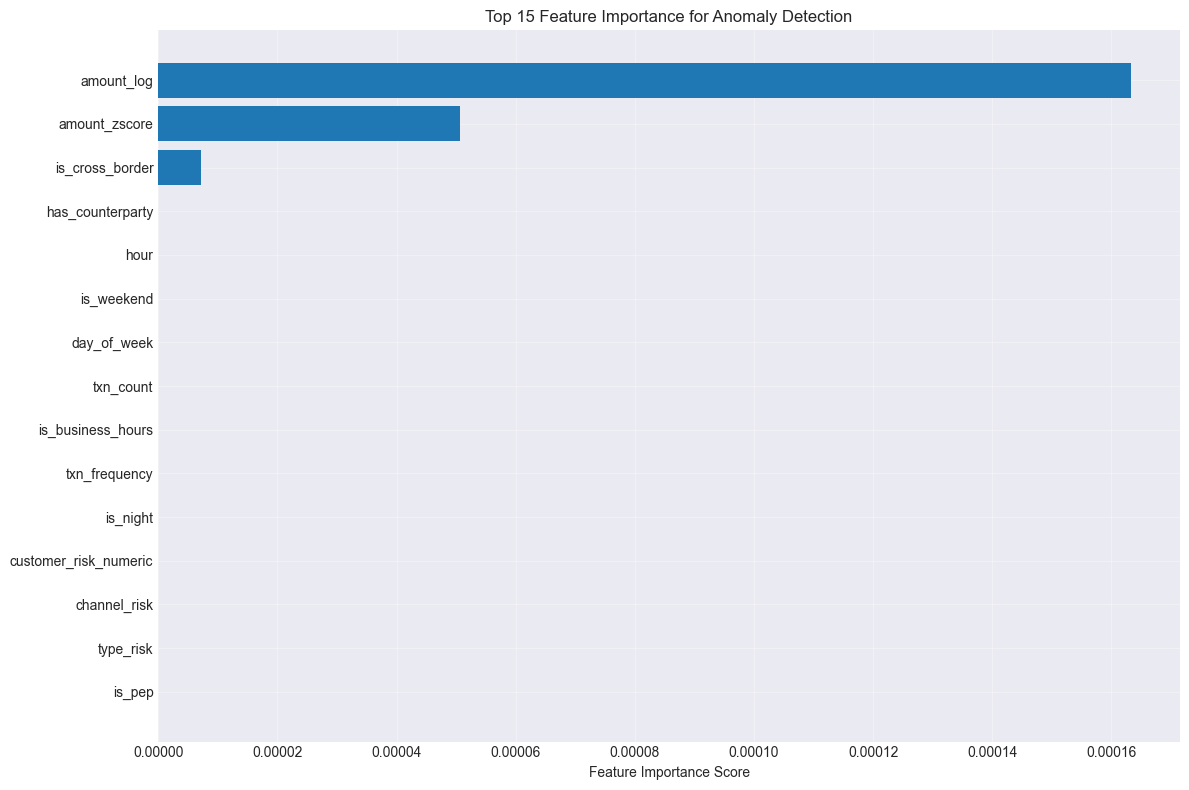

In [12]:
# Feature importance based on anomaly score variance
print("Analyzing feature importance...")

def calculate_feature_importance(model, X_scaled, feature_names):
    """
    Calculate feature importance by measuring how much each feature
    contributes to the anomaly score variance
    """
    baseline_scores = model.decision_function(X_scaled)
    feature_importance = []
    
    for i, feature in enumerate(feature_names):
        # Create a copy with this feature permuted
        X_permuted = X_scaled.copy()
        np.random.shuffle(X_permuted[:, i])
        
        # Calculate scores with permuted feature
        permuted_scores = model.decision_function(X_permuted)
        
        # Importance is the change in score variance
        importance = np.var(baseline_scores) - np.var(permuted_scores)
        feature_importance.append(importance)
    
    return np.array(feature_importance)

# Calculate feature importance
importance_scores = calculate_feature_importance(isolation_forest, X_test_scaled, anomaly_features)

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'feature': anomaly_features,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:8.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance Score')
plt.title('Top 15 Feature Importance for Anomaly Detection')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning and Model Optimization

In [13]:
# Hyperparameter tuning for Isolation Forest
print("Performing hyperparameter tuning...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.5, 0.7],
    'contamination': [contamination_rate * 0.8, contamination_rate, contamination_rate * 1.2],
    'max_features': [0.8, 1.0]
}

# Custom scorer for anomaly detection
def anomaly_scorer(estimator, X, y):
    """
    Custom scoring function that balances precision and recall
    """
    predictions = estimator.predict(X)
    predictions_binary = (predictions == -1).astype(int)
    
    if predictions_binary.sum() == 0 or y.sum() == 0:
        return 0.0
    
    cm = confusion_matrix(y, predictions_binary)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return f1
    return 0.0

# Grid search with cross-validation
grid_search = GridSearchCV(
    IsolationForest(random_state=42),
    param_grid,
    scoring=anomaly_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Running grid search...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test_scaled)
best_predictions_binary = (best_predictions == -1).astype(int)

print("\n=== Optimized Model Performance ===")
print(classification_report(y_test, best_predictions_binary, 
                          target_names=['Normal', 'Anomaly']))

Performing hyperparameter tuning...
Running grid search...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best parameters: {'contamination': np.float64(0.4935), 'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 300}
Best cross-validation score: 0.5064

=== Optimized Model Performance ===
              precision    recall  f1-score   support

      Normal       0.49      0.45      0.47       507
     Anomaly       0.48      0.52      0.50       493

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



## Clustering-based Anomaly Detection (DBSCAN)

Training DBSCAN clustering model...
DBSCAN found 24 anomalies (0.60%)
Number of clusters: 6


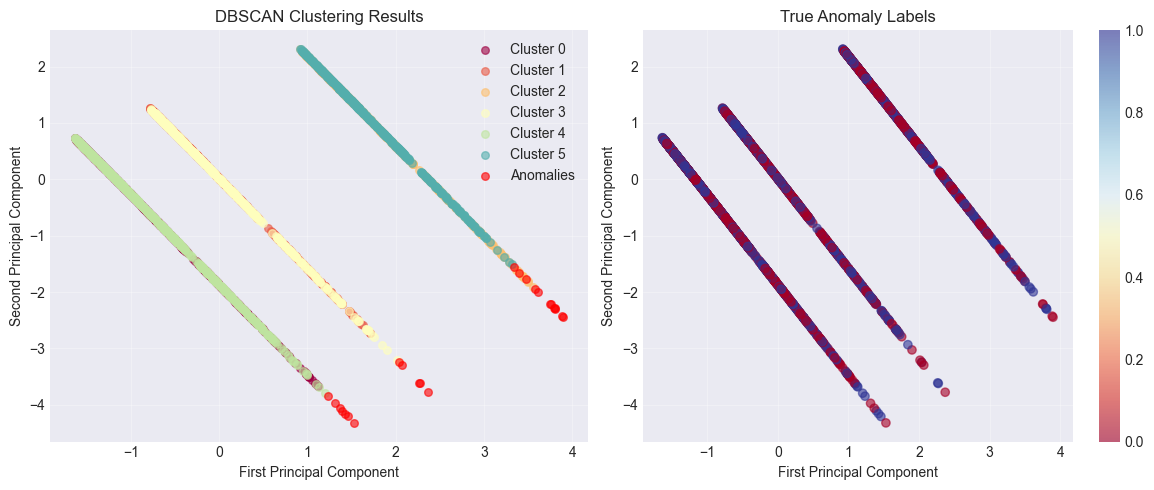


=== DBSCAN Performance ===
              precision    recall  f1-score   support

      Normal       0.51      1.00      0.67      2026
     Anomaly       0.58      0.01      0.01      1974

    accuracy                           0.51      4000
   macro avg       0.55      0.50      0.34      4000
weighted avg       0.54      0.51      0.35      4000



In [14]:
# DBSCAN clustering for anomaly detection
print("Training DBSCAN clustering model...")

# Use PCA-transformed data for faster computation
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')
cluster_labels = dbscan.fit_predict(X_train_pca[:, :5])  # Use first 5 PCA components

# Points labeled as -1 are considered outliers/anomalies
dbscan_anomalies = (cluster_labels == -1).astype(int)

print(f"DBSCAN found {dbscan_anomalies.sum()} anomalies ({dbscan_anomalies.mean()*100:.2f}%)")
print(f"Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")

# Visualize clusters in 2D PCA space
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'red'
        label = 'Anomalies'
    else:
        label = f'Cluster {k}'
    
    class_member_mask = (cluster_labels == k)
    plt.scatter(X_train_pca[class_member_mask, 0], X_train_pca[class_member_mask, 1], 
               c=[col], alpha=0.6, s=30, label=label)

plt.title('DBSCAN Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare with true labels
plt.subplot(1, 2, 2)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='RdYlBu', alpha=0.6)
plt.title('True Anomaly Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate DBSCAN performance
print("\n=== DBSCAN Performance ===")
print(classification_report(y_train, dbscan_anomalies, 
                          target_names=['Normal', 'Anomaly']))

## Model Persistence and Deployment Preparation

In [15]:
# Save the best performing model and preprocessing components
print("Saving trained models and preprocessing components...")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the isolation forest model
joblib.dump(best_model, '../models/anomaly_detection_model.pkl')
print("✓ Saved anomaly detection model")

# Save the feature scaler
joblib.dump(scaler, '../models/anomaly_scaler.pkl')
print("✓ Saved feature scaler")

# Save PCA transformer
joblib.dump(pca, '../models/anomaly_pca.pkl')
print("✓ Saved PCA transformer")

# Save feature names and importance
feature_info = {
    'feature_names': anomaly_features,
    'feature_importance': feature_importance_df.to_dict('records'),
    'model_params': best_model.get_params(),
    'performance_metrics': {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'average_precision': avg_precision
    }
}

import json
with open('../models/anomaly_model_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2, default=str)
print("✓ Saved model metadata")

# Create a prediction function for deployment
def predict_anomaly_score(transaction_features):
    """
    Predict anomaly score for a single transaction
    
    Args:
        transaction_features: dict with feature values
    
    Returns:
        anomaly_score: float between 0 and 1 (higher = more anomalous)
    """
    # Convert to DataFrame
    df = pd.DataFrame([transaction_features])
    
    # Ensure all required features are present
    for feature in anomaly_features:
        if feature not in df.columns:
            df[feature] = 0  # Default value
    
    # Select and order features
    X = df[anomaly_features].values
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Get anomaly score
    score = best_model.decision_function(X_scaled)[0]
    
    # Convert to 0-1 scale (higher = more anomalous)
    # Isolation forest returns negative scores for anomalies
    normalized_score = max(0, min(1, (0.5 - score)))
    
    return normalized_score

# Test the prediction function
print("\nTesting prediction function...")
test_transaction = X_test.iloc[0].to_dict()
test_score = predict_anomaly_score(test_transaction)
print(f"Test transaction anomaly score: {test_score:.4f}")

# Save the prediction function
joblib.dump(predict_anomaly_score, '../models/anomaly_predictor.pkl')
print("✓ Saved prediction function")

print("\n=== Model Deployment Summary ===")
print(f"Model type: Isolation Forest")
print(f"Training samples: {len(X_train):,}")
print(f"Features: {len(anomaly_features)}")
print(f"Performance (F1): {f1:.4f}")
print(f"Performance (ROC-AUC): {roc_auc:.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"Model files saved to: ../models/")

Saving trained models and preprocessing components...
✓ Saved anomaly detection model
✓ Saved feature scaler
✓ Saved PCA transformer
✓ Saved model metadata

Testing prediction function...
Test transaction anomaly score: 0.5972
✓ Saved prediction function

=== Model Deployment Summary ===
Model type: Isolation Forest
Training samples: 4,000
Features: 19
Performance (F1): 0.4850
Performance (ROC-AUC): 0.4874
False Positive Rate: 0.5247
Model files saved to: ../models/


## Model Validation and Business Impact Analysis

In [16]:
# Analyze model performance by different business segments
print("=== Business Impact Analysis ===")

# Get test predictions and scores
test_scores_normalized = -best_model.decision_function(X_test_scaled)
test_df = df_features.iloc[X_test.index].copy()
test_df['anomaly_score'] = test_scores_normalized
test_df['predicted_anomaly'] = test_predictions_binary
test_df['actual_anomaly'] = y_test.values

# Analysis by transaction amount ranges
amount_ranges = [
    (0, 1000, 'Small'),
    (1000, 10000, 'Medium'), 
    (10000, 100000, 'Large'),
    (100000, float('inf'), 'Very Large')
]

print("\nPerformance by Transaction Amount:")
for min_amt, max_amt, label in amount_ranges:
    mask = (test_df['base_amount'] >= min_amt) & (test_df['base_amount'] < max_amt)
    if mask.sum() > 0:
        subset_actual = test_df.loc[mask, 'actual_anomaly']
        subset_predicted = test_df.loc[mask, 'predicted_anomaly']
        
        if len(subset_actual) > 0 and subset_predicted.sum() > 0:
            precision = (subset_actual & subset_predicted).sum() / subset_predicted.sum()
            recall = (subset_actual & subset_predicted).sum() / subset_actual.sum() if subset_actual.sum() > 0 else 0
            print(f"{label:12s}: {mask.sum():5d} txns, Precision: {precision:.3f}, Recall: {recall:.3f}")

# Analysis by channels
print("\nPerformance by Channel:")
for channel in test_df['channel'].value_counts().head(5).index:
    mask = test_df['channel'] == channel
    if mask.sum() > 10:  # Only analyze channels with sufficient data
        subset_actual = test_df.loc[mask, 'actual_anomaly']
        subset_predicted = test_df.loc[mask, 'predicted_anomaly']
        
        if subset_predicted.sum() > 0:
            precision = (subset_actual & subset_predicted).sum() / subset_predicted.sum()
            recall = (subset_actual & subset_predicted).sum() / subset_actual.sum() if subset_actual.sum() > 0 else 0
            print(f"{channel:12s}: {mask.sum():5d} txns, Precision: {precision:.3f}, Recall: {recall:.3f}")

# High-confidence predictions analysis
high_confidence_threshold = np.percentile(test_scores_normalized, 95)
high_confidence_mask = test_scores_normalized >= high_confidence_threshold

print(f"\nHigh Confidence Predictions (top 5% scores):")
print(f"Threshold: {high_confidence_threshold:.4f}")
print(f"High confidence predictions: {high_confidence_mask.sum()}")
if high_confidence_mask.sum() > 0:
    hc_precision = y_test[high_confidence_mask].mean()
    print(f"Precision of high confidence predictions: {hc_precision:.4f}")

# Cost-benefit analysis simulation
print("\n=== Cost-Benefit Analysis ===")

# Assumptions for cost-benefit calculation
investigation_cost = 100  # Cost to investigate one alert (USD)
fraud_prevention_value = 10000  # Average value of prevented fraud (USD)
false_positive_cost = 50  # Cost of false positive (customer friction, etc.)

tp_benefit = tp * fraud_prevention_value
fp_cost = fp * (investigation_cost + false_positive_cost)
fn_cost = fn * fraud_prevention_value  # Missed fraud
tn_benefit = 0  # No direct benefit, but also no cost

total_benefit = tp_benefit - fp_cost - fn_cost
total_alerts = tp + fp
total_investigations = total_alerts * investigation_cost

print(f"True Positives: {tp} (Prevented fraud value: ${tp_benefit:,.0f})")
print(f"False Positives: {fp} (Cost: ${fp_cost:,.0f})")
print(f"False Negatives: {fn} (Missed fraud cost: ${fn_cost:,.0f})")
print(f"Investigation costs: ${total_investigations:,.0f}")
print(f"Net benefit: ${total_benefit:,.0f}")
print(f"ROI: {(total_benefit / total_investigations * 100):.1f}%" if total_investigations > 0 else "ROI: N/A")

print("\n=== Model Ready for Production Deployment ===")
print("Files saved in ../models/ directory:")
print("  - anomaly_detection_model.pkl (trained model)")
print("  - anomaly_scaler.pkl (feature scaler)")
print("  - anomaly_pca.pkl (PCA transformer)")
print("  - anomaly_predictor.pkl (prediction function)")
print("  - anomaly_model_info.json (metadata)")

=== Business Impact Analysis ===

Performance by Transaction Amount:
Small       :   197 txns, Precision: 0.482, Recall: 1.000
Medium      :   803 txns, Precision: 0.474, Recall: 0.372

Performance by Channel:
POS         :   264 txns, Precision: 0.511, Recall: 0.540
ONLINE      :   250 txns, Precision: 0.448, Recall: 0.444
ATM         :   249 txns, Precision: 0.449, Recall: 0.479
BRANCH      :   237 txns, Precision: 0.500, Recall: 0.508

High Confidence Predictions (top 5% scores):
Threshold: 0.0722
High confidence predictions: 50
Precision of high confidence predictions: 0.4200

=== Cost-Benefit Analysis ===
True Positives: 243 (Prevented fraud value: $2,430,000)
False Positives: 266 (Cost: $39,900)
False Negatives: 250 (Missed fraud cost: $2,500,000)
Investigation costs: $50,900
Net benefit: $-109,900
ROI: -215.9%

=== Model Ready for Production Deployment ===
Files saved in ../models/ directory:
  - anomaly_detection_model.pkl (trained model)
  - anomaly_scaler.pkl (feature scaler)